In [5]:
def set_size(width_pt, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

def set_size_square(width_pt, fraction=1, subplots=(1, 1)):
    """Set figure dimensions for square subplots to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt

    # Figure height in inches, calculated to make subplots square
    # The height of the total figure is the width multiplied by the ratio of rows to columns.
    fig_height_in = fig_width_in * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

# import matplotlib as mpl
# mpl.use('pgf')
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import pandas as pd
import plotly.graph_objects as go
from scipy.optimize import curve_fit

# Update matplotlib settings
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": r"""
\usepackage[T1]{fontenc}
\usepackage{amsmath}
\usepackage{amsfonts}
\def\mathdefault#1{#1}
"""
})
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 10
# The amsmath package is needed for \text{}, fontenc is for font encoding
# Fix the LaTeX preamble to define mathdefault and include necessary packages
plt.rcParams["text.latex.preamble"] = r"""
\usepackage[T1]{fontenc}
\usepackage{amsmath}
\usepackage{amsfonts}
"""
doc_size=441.01773

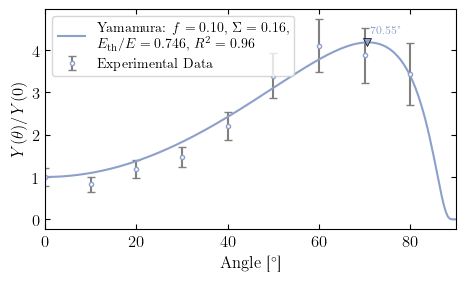

In [9]:
cmap = plt.get_cmap('Set2')
exp_color = cmap(2)    # Experimental

def yamamura_extended(theta_deg, f, sigma, eth_e_ratio):
    """
    Extended Yamamura sputter yield function, fitting for the Eth/E ratio.
    theta_deg: incident angle in degrees
    f, sigma: fitting parameters
    eth_e_ratio: The ratio Eth/E
    """
    theta_rad = np.deg2rad(theta_deg)
    cos_theta = np.cos(theta_rad)
    cos_theta[cos_theta == 0] = 1e-9 # Avoid division by zero
    x = 1 / cos_theta
    
    # The ratio must be between 0 and 1 for the math to be valid
    if not (0 <= eth_e_ratio < 1):
        return np.inf

    sqrt_eth_e_ratio = np.sqrt(eth_e_ratio)
    
    term1 = (x**f) * np.exp(-sigma * (x - 1))
    term2 = (1 - sqrt_eth_e_ratio / x) / (1 - sqrt_eth_e_ratio)
    return term1 * term2

try:
    df = pd.read_excel('Series1.xlsx')

    # --- Plot for Etching Rate ---
    if 'Angle' in df.columns and 'Normalized' in df.columns:
        # Prefer existing normalized data if present
        if 'Normalized' in df.columns:
            df_normal_col = 'Normalized'
        else:
            # Normalize by the value at Angle = 0
            etch_rate_at_0 = df[df['Angle'] == 0]['Etching Rate (nm/min)'].iloc[0]
            df['Normalized'] = df['Etching Rate (nm/min)'] / etch_rate_at_0
            df_normal_col = 'Normalized'

        angle_data = df['Angle'].values
        norm_etch_rate_data = df[df_normal_col].values

        # Fit 2: Extended Yamamura with Eth/E ratio
        # Initial guesses for f, sigma, eth_e_ratio. Bounds to keep ratio between 0 and 1.
        popt2, pcov2 = curve_fit(yamamura_extended, angle_data, norm_etch_rate_data, p0=[1, 1, 0.1], bounds=([-np.inf, -np.inf, 0], [np.inf, np.inf, 1]), maxfev=30000)
        f_opt2, sigma_opt2, eth_e_ratio_opt2 = popt2
        residuals2 = norm_etch_rate_data - yamamura_extended(angle_data, *popt2)
        ss_res2 = np.sum(residuals2**2)
        ss_tot2 = np.sum((norm_etch_rate_data - np.mean(norm_etch_rate_data))**2)
        r_squared2 = 1 - (ss_res2 / ss_tot2)

        # Create the scatter plot using axes and optional error bars
        fig, ax = plt.subplots(figsize=set_size(doc_size,fraction=0.79))
        yerr = df.get('Error bars', df.get('Error Bars', None))
        ax.errorbar(df['Angle'], df[df_normal_col], yerr=yerr, fmt='.', mfc='white', mec=exp_color, ecolor='gray', capsize=3, label='Experimental Data')

        # Plot the fitted curves
        angle_fit = np.linspace(min(angle_data), 90, 200)

        fit_label2 = (f'Yamamura: $f = {f_opt2:.2f}$, '
                     r'$\Sigma = ' + f'{sigma_opt2:.2f}$, ' + '\n'
                     f'$E_{{\\text{{th}}}}/E = {eth_e_ratio_opt2:.3f}$, $R^2 = {r_squared2:.2f}$')
        
        # Plot second fit and find its peak
        yamamura_fit2 = yamamura_extended(angle_fit, *popt2)
        ax.plot(angle_fit, yamamura_fit2, '-', color=exp_color, label=fit_label2)
        
        # Find and highlight peak of second fit
        peak2_idx = np.argmax(yamamura_fit2)
        peak2_angle = angle_fit[peak2_idx]
        peak2_yield = yamamura_fit2[peak2_idx]
        ax.plot(peak2_angle, peak2_yield, 'v', color=exp_color, markersize=6, markeredgecolor='black', markeredgewidth=0.5)
        ax.annotate(f'{peak2_angle:.2f}°', xy=(peak2_angle, peak2_yield), xytext=(2, 12), textcoords='offset points', ha='left', va='top', fontsize=8, color=exp_color)

        # Add labels and title (keep your original label text/rotation)
        ax.set_xlabel(r'Angle [$^{\circ}$]')
        ax.set_ylabel(r'$Y(\theta)/Y(0)$')
        # plt.title('Normalized Etch Rate vs Angle')
        ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, bottom=True, left=True)
        ax.set_xlim(0, 90)
        ax.legend()
        fig.tight_layout()
        plt.savefig('SputteringYieldExp.pgf', format='pgf')
        plt.show()
    else:
        print("Error: 'Angle' or 'Normalized' column not found for the first plot.")

except FileNotFoundError:
    print("Error: 'Series1.xlsx' not found. Please make sure the file is in the correct directory.")
except IndexError:
    print("Error: Could not find a value at Angle = 0 for normalization. Please check your data.")
except RuntimeError:
    print("Error: Could not find optimal parameters for one of the fits. Consider providing different initial guesses (p0) or bounds.")
except Exception as e:
    print(f"An error occurred: {e}")


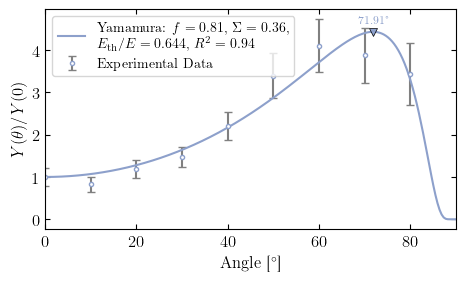

In [10]:
# choose a colormap for consistent matching colors
cmap = plt.get_cmap('Set2')
exp_color = cmap(2)    # Experimental

def yamamura_extended(theta_deg, f, sigma, eth_e_ratio):
    """
    Extended Yamamura sputter yield function, fitting for the Eth/E ratio.
    theta_deg: incident angle in degrees
    f, sigma: fitting parameters
    eth_e_ratio: The ratio Eth/E
    """
    theta_rad = np.deg2rad(theta_deg)
    cos_theta = np.cos(theta_rad)
    cos_theta[cos_theta == 0] = 1e-9 # Avoid division by zero
    x = 1 / cos_theta
    
    # The ratio must be between 0 and 1 for the math to be valid
    if not (0 <= eth_e_ratio < 1):
        return np.inf

    sqrt_eth_e_ratio = np.sqrt(eth_e_ratio)
    
    term1 = (x**f) * np.exp(-sigma * (x - 1))
    term2 = (1 - sqrt_eth_e_ratio / x) / (1 - sqrt_eth_e_ratio)
    return term1 * term2

try:
    df = pd.read_excel('Series1.xlsx')

    # --- Plot for Etching Rate ---
    if 'Angle' in df.columns and 'Normalized' in df.columns:
        # Prefer existing normalized data if present
        if 'Normalized' in df.columns:
            df_normal_col = 'Normalized'
        else:
            # Normalize by the value at Angle = 0
            etch_rate_at_0 = df[df['Angle'] == 0]['Etching Rate (nm/min)'].iloc[0]
            df['Normalized'] = df['Etching Rate (nm/min)'] / etch_rate_at_0
            df_normal_col = 'Normalized'

        angle_data = df['Angle'].values
        norm_etch_rate_data = df[df_normal_col].values

        # --- Prepare sigma (error bars) for weighted fitting ---
        raw_sigma = df.get('Error bars', df.get('Error Bars', None))
        if raw_sigma is None:
            sigma = None
        else:
            sigma_series = pd.to_numeric(raw_sigma, errors='coerce')
            if sigma_series.isnull().all():
                sigma = None
            else:
                # use median of positive errors as baseline; fallback small value if none
                pos = sigma_series[sigma_series > 0]
                if len(pos) > 0:
                    median_pos = pos.median()
                    fallback = median_pos * 1e-3
                else:
                    median_pos = np.nanmedian(np.abs(df[df_normal_col].astype(float))) * 1e-3
                    fallback = median_pos
                sigma_series = sigma_series.fillna(median_pos)
                sigma_series[sigma_series == 0] = fallback
                sigma = sigma_series.values

        # --- Fit Yamamura function (extended) with sigma weighting if available ---
        # Fit 2: Extended Yamamura with Eth/E ratio
        popt2, pcov2 = curve_fit(
            yamamura_extended,
            angle_data,
            norm_etch_rate_data,
            p0=[1, 1, 0.1],
            bounds=([-np.inf, -np.inf, 0], [np.inf, np.inf, 1]),
            sigma=raw_sigma,
            absolute_sigma=True,
            maxfev=30000,
        )
        f_opt2, sigma_opt2, eth_e_ratio_opt2 = popt2
        residuals2 = norm_etch_rate_data - yamamura_extended(angle_data, *popt2)
        ss_res2 = np.sum(residuals2**2)
        ss_tot2 = np.sum((norm_etch_rate_data - np.mean(norm_etch_rate_data))**2)
        r_squared2 = 1 - (ss_res2 / ss_tot2)

        # Create the scatter plot using axes and optional error bars
        fig, ax = plt.subplots(figsize=set_size(doc_size, fraction=0.79))
        yerr = df.get('Error bars', df.get('Error Bars', None))
        ax.errorbar(df['Angle'], df[df_normal_col], yerr=yerr, fmt='.', mfc='white', mec=exp_color, ecolor='gray', capsize=3, label='Experimental Data')

        # Plot the fitted curves
        angle_fit = np.linspace(min(angle_data), 90, 200)

        fit_label2 = (f'Yamamura: $f = {f_opt2:.2f}$, '
                     r'$\Sigma = ' + f'{sigma_opt2:.2f}$, ' + '\n'
                     f'$E_{{\\text{{th}}}}/E = {eth_e_ratio_opt2:.3f}$, $R^2 = {r_squared2:.2f}$')
        
        # Plot second fit and find its peak
        yamamura_fit2 = yamamura_extended(angle_fit, *popt2)
        ax.plot(angle_fit, yamamura_fit2, '-', color=exp_color, label=fit_label2)
        
        # Find and highlight peak of second fit
        peak2_idx = np.argmax(yamamura_fit2)
        peak2_angle = angle_fit[peak2_idx]
        peak2_yield = yamamura_fit2[peak2_idx]
        ax.plot(peak2_angle, peak2_yield, 'v', color=exp_color, markersize=6, markeredgecolor='black', markeredgewidth=0.5)
        ax.annotate(f'{peak2_angle:.2f}°', xy=(peak2_angle, peak2_yield), xytext=(0, 12), textcoords='offset points', ha='center', va='top', fontsize=8, color=exp_color)

        # Add labels and title (keep your original label text/rotation)
        ax.set_xlabel(r'Angle [$^{\circ}$]')
        ax.set_ylabel(r'$Y(\theta)/Y(0)$')
        # plt.title('Normalized Etch Rate vs Angle')
        ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, bottom=True, left=True)
        ax.set_xlim(0, 90)
        ax.legend()
        fig.tight_layout()
        plt.savefig('SputteringYieldExpError.pgf', format='pgf')
        plt.show()
    else:
        print("Error: 'Angle' or 'Normalized' column not found for the first plot.")

except FileNotFoundError:
    print("Error: 'Series1.xlsx' not found. Please make sure the file is in the correct directory.")
except IndexError:
    print("Error: Could not find a value at Angle = 0 for normalization. Please check your data.")
except RuntimeError:
    print("Error: Could not find optimal parameters for one of the fits. Consider providing different initial guesses (p0) or bounds.")
except Exception as e:
    print(f"An error occurred: {e}")
